In [1]:
import sys

In [2]:
sys.path.append("./")

# Dataset

In [3]:
from dataSetUtils import prepare_dataset, load_npz_as_datasets

In [4]:
prepare_dataset("../COMMUDataset/losses/")

Shapes: (34619, 256) (7419, 256) (7419, 256)
Classes: ['accompaniment', 'bass', 'main_melody', 'pad', 'riff', 'sub_melody']


'commu_z_txt_trackrole_dataset.npz'

In [5]:
ls

__pycache__/                     classifierUtils.py
best.pth                         commu_z_txt_trackrole_dataset.npz
classifier.ipynb                 commu_z_txt_trackrole_dataset_label_map.json
classifierOriginalLabels001.pth  dataSetUtils.py


In [6]:
train_ds, val_ds, test_ds, class_names = load_npz_as_datasets("./commu_z_txt_trackrole_dataset.npz")

In [7]:
print("Tamanho treino:", len(train_ds))
print("Tamanho validação:", len(val_ds))
print("Tamanho teste:", len(test_ds))

Tamanho treino: 34619
Tamanho validação: 7419
Tamanho teste: 7419


In [8]:
# Pega o primeiro exemplo só para ver o shape da entrada
sample_X, sample_y = train_ds[0]
D = sample_X.shape[0]             # tamanho do vetor z_txt
C = len(class_names)              # número de classes

print("D:", D, "C:", C)

D: 256 C: 6


# Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class OneLayerNetMC(nn.Module):
    def __init__(self, input_size, hidden_neurons, output_size):
        super().__init__()
        self.linear_one = nn.Linear(input_size, hidden_neurons)
        self.linear_two = nn.Linear(hidden_neurons, output_size)

    def forward(self, x):
        x = torch.relu(self.linear_one(x)) # ReLU na oculta
        logits = self.linear_two(x) # logits
        return logits 

In [12]:
model = OneLayerNetMC(input_size = D, hidden_neurons = 32, output_size = C).to(device)

In [13]:
model.eval()

OneLayerNetMC(
  (linear_one): Linear(in_features=256, out_features=32, bias=True)
  (linear_two): Linear(in_features=32, out_features=6, bias=True)
)

### Arquitetura e dimensões

(X) [batch_size, 256]

   ---> Linear(W1: [256, 32], b1: [32])
   
       ---> saída: [batch_size, 32]
       
       ---> ReLU (aplicado elemento a elemento)
       
           ---> (X_oculta) [batch_size, 32]
           
               ---> Linear(W2: [32, 6], b2: [6])
               
                   ---> logits: [batch_size, 6]

In [14]:
X_latents = torch.stack([train_ds[i][0] for i in range(len(train_ds))]).to(device).float()
y_labels  = torch.tensor([train_ds[i][1] for i in range(len(train_ds))]).to(device).long()

In [15]:
model.parameters

<bound method Module.parameters of OneLayerNetMC(
  (linear_one): Linear(in_features=256, out_features=32, bias=True)
  (linear_two): Linear(in_features=32, out_features=6, bias=True)
)>

In [16]:
criterion = nn.CrossEntropyLoss() # perda do modelo
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9) # atualiza os pesos do modelo 

https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [17]:
#def reset_weights(m):
 #   if isinstance(m, nn.Linear):
  #      m.reset_parameters()  # reinicializa pesos e bias como no início

#model.apply(reset_weights)

In [18]:
for name, param in model.named_parameters():
    print(name, param.shape)
    print(param)  # valores atuais

linear_one.weight torch.Size([32, 256])
Parameter containing:
tensor([[ 0.0323,  0.0314, -0.0307,  ..., -0.0355,  0.0557, -0.0307],
        [ 0.0006, -0.0437,  0.0566,  ..., -0.0600,  0.0209,  0.0135],
        [ 0.0338, -0.0156,  0.0015,  ...,  0.0624,  0.0107,  0.0428],
        ...,
        [-0.0047, -0.0409,  0.0002,  ..., -0.0203,  0.0125, -0.0508],
        [-0.0411,  0.0392, -0.0232,  ...,  0.0618, -0.0159, -0.0265],
        [ 0.0156, -0.0052, -0.0493,  ...,  0.0588, -0.0589, -0.0537]],
       requires_grad=True)
linear_one.bias torch.Size([32])
Parameter containing:
tensor([ 0.0071, -0.0616, -0.0586, -0.0006, -0.0229,  0.0300,  0.0080, -0.0373,
         0.0339,  0.0033, -0.0077,  0.0013,  0.0239, -0.0172,  0.0280, -0.0481,
         0.0585,  0.0623,  0.0053,  0.0013,  0.0572,  0.0079,  0.0417, -0.0146,
         0.0073,  0.0091,  0.0317,  0.0173, -0.0073, -0.0108, -0.0481,  0.0040],
       requires_grad=True)
linear_two.weight torch.Size([6, 32])
Parameter containing:
tensor([[-0.08

In [19]:
best_val = float('inf')
patience = 100
since_best = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=25, verbose=True)

# --- preparar tensores de treino (X_latents, y_labels) ---
with torch.no_grad():
    X_latents = torch.stack([train_ds[i][0] for i in range(len(train_ds))]).to(device).float()
    y_labels  = torch.tensor([train_ds[i][1] for i in range(len(train_ds))]).to(device).long()

# --- preparar tensores de validação (Xv, yv) ---
with torch.no_grad():
    Xv = torch.stack([val_ds[i][0] for i in range(len(val_ds))]).to(device).float()
    yv = torch.tensor([val_ds[i][1] for i in range(len(val_ds))]).to(device).long()

epochs = 2000

for epoch in range(epochs):
    model.train() # coloca o modelo em modo treino
    optimizer.zero_grad() # evita que gradientes de iterações anteriores se somem aos atuais
    logits = model(X_latents) #
    loss = criterion(logits, y_labels)
    loss.backward() # computa ∂loss/∂param e grava em param.grad
    optimizer.step() # Atualiza os pesos usando os gradientes (SGD com momentum aqui)

    # validação
    model.eval()
    with torch.no_grad():
        logits_v = model(Xv)
        val_loss = nn.CrossEntropyLoss()(logits_v, yv).item()
        val_acc = (logits_v.argmax(1) == yv).float().mean().item()

    scheduler.step(val_loss)

    # early stopping
    if val_loss + 1e-3 < best_val:
        best_val = val_loss
        since_best = 0
        torch.save(model.state_dict(), "best.pth")  # salva o melhor
    else:
        since_best += 1
        if since_best >= patience:
            print(f"Early stop at epoch {epoch+1}. Best val_loss={best_val:.4f}")
            break

    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            preds = logits.argmax(dim=1)
            acc = (preds == y_labels).float().mean().item() # Comparação booleana → float (1 acerto / 0 erro) → média → .item()
        print(f'epoch {epoch+1}: loss={loss.item():.4f} acc={acc:.3f}')

/usr/local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch 100: loss=0.8382 acc=0.676
epoch 200: loss=0.7111 acc=0.728
epoch 300: loss=0.6631 acc=0.742
epoch 400: loss=0.6337 acc=0.753
epoch 500: loss=0.6121 acc=0.762
epoch 600: loss=0.5945 acc=0.768
epoch 700: loss=0.5794 acc=0.774
epoch 800: loss=0.5658 acc=0.781
epoch 900: loss=0.5534 acc=0.785
epoch 1000: loss=0.5419 acc=0.789
epoch 1100: loss=0.5313 acc=0.793
epoch 1200: loss=0.5214 acc=0.797
epoch 1300: loss=0.5122 acc=0.801
epoch 1400: loss=0.5036 acc=0.804
epoch 1500: loss=0.4956 acc=0.807
Early stop at epoch 1600. Best val_loss=0.6177


In [20]:
with torch.no_grad():
    Xv = torch.stack([val_ds[i][0] for i in range(len(val_ds))]).to(device).float()
    yv = torch.tensor([val_ds[i][1] for i in range(len(val_ds))]).to(device).long()
    logits_v = model(Xv)
    val_loss = nn.CrossEntropyLoss()(logits_v, yv).item()
    val_acc = (logits_v.argmax(1) == yv).float().mean().item()
print(f"val_loss={val_loss:.4f} val_acc={val_acc:.3f}")

val_loss=0.6169 val_acc=0.750


In [21]:
torch.save(model.state_dict(), "classifierOriginalLabels001.pth")

# Olhando o classificador

In [22]:
from classifierUtils import evaluate_split, top_confusion_files_from_split


Per-class metrics:
class                 support     prec      rec       f1  acc_cls
accompaniment            1659    0.899    0.866    0.882    0.866
bass                      303    0.788    0.799    0.793    0.799
main_melody              2049    0.688    0.746    0.716    0.746
pad                      1247    0.845    0.824    0.834    0.824
riff                      831    0.778    0.711    0.743    0.711
sub_melody               1330    0.559    0.553    0.556    0.553

Averages:
macro: prec=0.759 recall=0.750 f1=0.754
micro: prec=0.750 recall=0.750 f1=0.750 acc=0.750


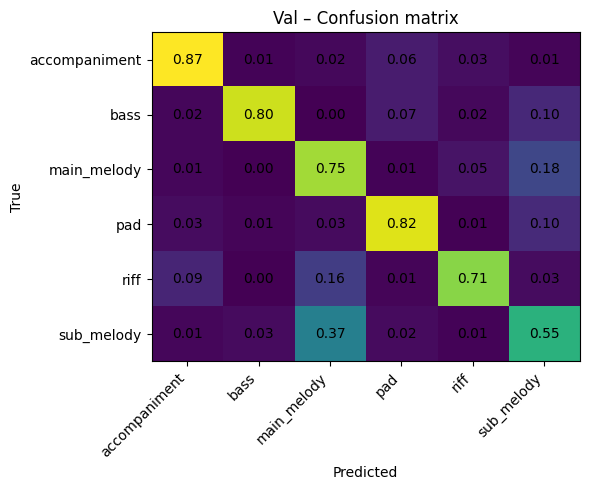

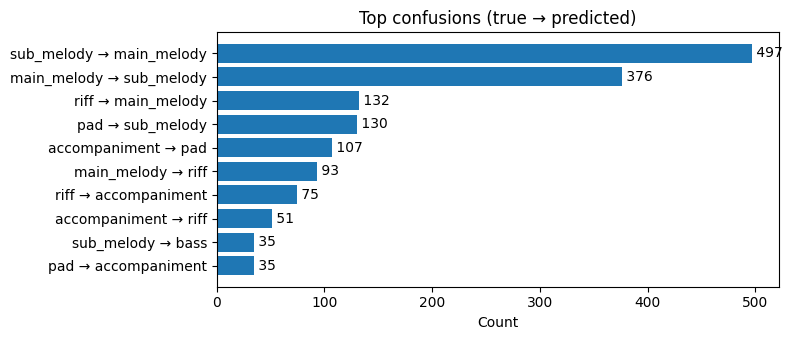

In [23]:
# Validação
cm_val, metrics_val = evaluate_split(model, val_ds, device, class_names=class_names,
                                     normalize_cm=True, title="Val – Confusion matrix")

In [27]:
import importlib
import classifierUtils #as cu  # ajuste conforme seu caminho real
importlib.reload(classifierUtils)

<module 'classifierUtils' from '/workspace/vae-tuning-texutres/classifier/classifierUtils.py'>

In [28]:
#from classifierUtils import top_confusion_files_from_split

files_dict = top_confusion_files_from_split(model, val_ds, device, cm_val, n_files=5)

for (true_cls, pred_cls), files in files_dict.items():
    print(f"{class_names[true_cls]} → {class_names[pred_cls]}: {files}")

sub_melody → main_melody: ['commu00726-007.npz', 'commu02840-002.npz', 'commu00228-006.npz', 'commu10921-002.npz', 'commu07411-005.npz']
main_melody → sub_melody: ['commu00632-002.npz', 'commu03681-001.npz', 'commu00563-001.npz', 'commu01866-003.npz', 'commu08084-001.npz']
riff → main_melody: ['commu08564-003.npz', 'commu05215-001.npz', 'commu06107-001.npz', 'commu08477-004.npz', 'commu04172-006.npz']
pad → sub_melody: ['commu03110-006.npz', 'commu08857-001.npz', 'commu01484-007.npz', 'commu11108-002.npz', 'commu10950-002.npz']
accompaniment → pad: ['commu06627-002.npz', 'commu02652-003.npz', 'commu05088-001.npz', 'commu09793-006.npz', 'commu10836-013.npz']
main_melody → riff: ['commu01387-006.npz', 'commu02702-002.npz', 'commu06406-005.npz', 'commu04093-003.npz', 'commu01524-004.npz']
riff → accompaniment: ['commu00146-003.npz', 'commu00192-004.npz', 'commu10230-001.npz', 'commu07980-001.npz', 'commu10360-002.npz']
accompaniment → riff: ['commu01146-006.npz', 'commu08418-002.npz', 'co